2025-07-31 09:45:07 INFO     xscen.config    Updated the config with ../paths_obs.yml.
2025-07-31 09:45:07 INFO     xscen.config    Updated the config with ../config_obs.yml.
/tmp/ipykernel_5928/4064933371.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

/tmp/ipykernel_5928/4064933371.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Régions administratives du Québec


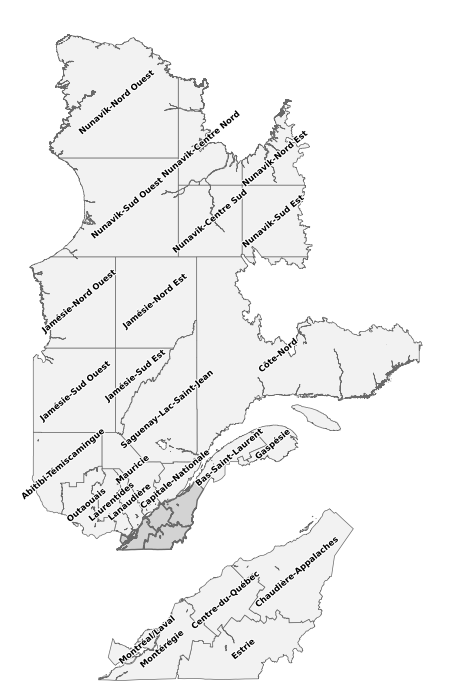

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt
from xscen.config import CONFIG
import xscen as xs
import matplotlib.patheffects as path_effects

facecolor_land = "#f2f2f2"
facecolor_highlight = "lightgray"

# Load config
xs.load_config("../paths_obs.yml", "../config_obs.yml", verbose=(__name__ == "__main__"), reset=True)

# Load shapefile
gdf = gpd.read_file("../"+CONFIG["regional_mean"]["region"]["shape"])

# Get y-coordinate of Outaouais centroid
outaouais_geom = gdf[gdf["name"] == "Outaouais"].geometry.values[0]
outaouais_y = outaouais_geom.centroid.y

# Split regions
gdf_above = gdf[gdf.geometry.centroid.y >= outaouais_y]
gdf_below = gdf[gdf.geometry.centroid.y < outaouais_y]

# Create single figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), gridspec_kw={'height_ratios': [3, 1]})

# --- Subplot 1: All regions ---
# Plot regions below Outaouais with thick black border
gdf_below.plot(
    ax=ax1,
    facecolor=facecolor_highlight,
    edgecolor='dimgray',
    linewidth=1.0,
    alpha=1
)

# Plot regions above or equal to Outaouais
gdf_above.plot(
    ax=ax1,
    facecolor=facecolor_land,
    edgecolor='dimgray',
    linewidth=0.5,
    alpha=1#0.3
)

# Annotate only regions above Outaouais
for idx, row in gdf_above.iterrows():
    centroid = row.geometry.centroid
    ax1.annotate(
        row["name"],
        xy=(centroid.x, centroid.y),
        fontsize=6,
        ha='center',
        va='center',
        rotation=40,
        fontweight='bold',
        path_effects=[path_effects.withStroke(linewidth=1.5, foreground='white')]
    )

ax1.axis("off")

# --- Subplot 2: Only southern regions, now with labels ---
gdf_below.plot(
    ax=ax2,
    facecolor=facecolor_land,
    edgecolor='dimgray',
    linewidth=0.5,
    alpha=1#0.3
)

for idx, row in gdf_below.iterrows():
    centroid = row.geometry.centroid
    ax2.annotate(
        row["name"],
        xy=(centroid.x, centroid.y),
        fontsize=6,
        ha='center',
        va='center',
        rotation=40,
        fontweight='bold',
        path_effects=[path_effects.withStroke(linewidth=1.5, foreground='white')]
    )

ax2.axis("off")

plt.subplots_adjust(hspace=-0.2, top=0.96)
print("Régions administratives du Québec")
plt.show()
